Load all required modules

In [28]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from scipy.stats import kruskal
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from chembl_webresource_client.new_client import new_client


Select and retrieve bioactivity data for SARS coronavirus 3C-like proteinase

In [81]:

target = new_client.target
target_query = target.search('CHEMBL3927')
targets = pd.DataFrame.from_dict(target_query)
print(targets)

selected_target = targets.target_chembl_id[0]
print(selected_target)

activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
df = pd.DataFrame.from_dict(res)
print(df.head(3))

  cross_references                                           organism  \
0               []  Severe acute respiratory syndrome-related coro...   

                             pref_name  score  species_group_flag  \
0  SARS coronavirus 3C-like proteinase   18.0               False   

  target_chembl_id                                  target_components  \
0       CHEMBL3927  [{'accession': 'P0C6U8', 'component_descriptio...   

      target_type  tax_id  
0  SINGLE PROTEIN  694009  
CHEMBL3927
  action_type activity_comment  activity_id activity_properties  \
0        None             None      1480935                  []   
1        None             None      1480936                  []   
2        None             None      1481061                  []   

  assay_chembl_id                                  assay_description  \
0    CHEMBL829584  In vitro inhibitory concentration against SARS...   
1    CHEMBL829584  In vitro inhibitory concentration against SARS...   
2    CHEMBL8308

Just checking the fetched data

In [82]:
df.shape
df[df.standard_value.isnull()] # null could mean not active

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
220,None,Not Active,13513210,[],CHEMBL2445678,Inhibition of SARS coronavirus 3CLpro,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome-related coro...,SARS coronavirus 3C-like proteinase,694009,None,None,IC50,None,None,None,None
222,None,Not Active,13513212,[],CHEMBL2445678,Inhibition of SARS coronavirus 3CLpro,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome-related coro...,SARS coronavirus 3C-like proteinase,694009,None,None,IC50,None,None,None,None


In [83]:
df2 = df[df.standard_value.notna()]
df2
     

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,1480935,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome-related coro...,SARS coronavirus 3C-like proteinase,694009,None,None,IC50,uM,UO_0000065,None,7.2
1,None,None,1480936,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome-related coro...,SARS coronavirus 3C-like proteinase,694009,None,None,IC50,uM,UO_0000065,None,9.4
2,None,None,1481061,[],CHEMBL830868,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome-related coro...,SARS coronavirus 3C-like proteinase,694009,None,None,IC50,uM,UO_0000065,None,13.5
3,None,None,1481065,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome-related coro...,SARS coronavirus 3C-like proteinase,694009,None,None,IC50,uM,UO_0000065,None,13.11
4,None,None,1481066,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome-related coro...,SARS coronavirus 3C-like proteinase,694009,None,None,IC50,uM,UO_0000065,None,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25516041,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5336133,Inhibition of SARS-CoV N-terminal 6His-SUMO-ta...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome-related coro...,SARS coronavirus 3C-like proteinase,694009,None,None,pIC50,None,UO_0000065,None,6.42
243,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25516042,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5336133,Inhibition of SARS-CoV N-terminal 6His-SUMO-ta...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome-related coro...,SARS coronavirus 3C-like proteinase,694009,None,None,IC50,uM,UO_0000065,None,0.165
244,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25516043,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5336133,Inhibition of SARS-CoV N-terminal 6His-SUMO-ta...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome-related coro...,SARS coronavirus 3C-like proteinase,694009,None,None,IC50,uM,UO_0000065,None,0.161
245,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25516044,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5336133,Inhibition of SARS-CoV N-terminal 6His-SUMO-ta...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome-related coro...,SARS coronavirus 3C-like proteinase,694009,None,None,pIC50,None,UO_0000065,None,6.78


In [84]:
df.activity_comment.value_counts()

activity_comment
Not Active    2
Name: count, dtype: int64

In [85]:
df2.loc[:, 'bioactivity_class'] = df2['standard_value'].apply(lambda x: 
    "inactive" if float(x) >= 10000 else 
    "active" if float(x) <= 1000 else 
    "intermediate"
)

/var/folders/9k/pvsw629j2t31mhtstdw1d_p00000gn/T/ipykernel_57976/3449385694.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:, 'bioactivity_class'] = df2['standard_value'].apply(lambda x:


In [86]:
selection = ['molecule_chembl_id', 'canonical_smiles', 'standard_value','bioactivity_class']
df3 = df2[selection]
df3.head(3)

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive


Function to calculate the lipinski scores from the smiles

In [87]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors
     

In [88]:
df_lipinski = lipinski(df3.canonical_smiles)


In [89]:
df_combined = pd.concat([df3,df_lipinski], axis=1)
df_combined.head(3)

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate,281.271,1.89262,0.0,5.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate,415.589,3.81320,0.0,2.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive,421.190,2.66050,0.0,4.0


Converting IC50 to pIC50

In [90]:
def pIC50(df, column_name):
    df['pIC50'] = -np.log10(df[column_name] * 1e-9)  # Vectorized operation
    return df.drop(columns=[column_name])

In [91]:
df_combined['standard_value'] = pd.to_numeric(df_combined['standard_value'], errors='coerce')

df_combined['standard_value_norm'] = np.minimum(df_combined['standard_value'], 100000000)  # Vectorized operation
df_combined.drop(columns=['standard_value'])
df_combined.standard_value_norm.describe()


count    2.450000e+02
mean     6.893878e+04
std      1.851962e+05
min      5.000000e+01
25%      5.000000e+03
50%      1.500000e+04
75%      4.700000e+04
max      2.000000e+06
Name: standard_value_norm, dtype: float64

In [92]:

df_final = pIC50(df_combined, 'standard_value_norm')
df_final

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.00,intermediate,281.271,1.89262,0.0,5.0,5.142668
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.00,intermediate,415.589,3.81320,0.0,2.0,5.026872
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.00,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.00,inactive,293.347,3.63080,0.0,3.0,4.882397
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.00,intermediate,338.344,3.53900,0.0,5.0,5.698970
...,...,...,...,...,...,...,...,...,...
244,CHEMBL2365410,CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC1C...,161.00,active,485.559,0.54470,5.0,7.0,6.793174
245,CHEMBL5436771,S=C([S-])NCc1cccnc1.[K+],165.96,active,NaN,NaN,NaN,NaN,6.779997
246,CHEMBL2365410,CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC1C...,162.18,active,NaN,NaN,NaN,NaN,6.790003
220,NaN,NaN,NaN,NaN,557.636,4.42230,2.0,9.0,NaN


In [93]:
df_final.bioactivity_class.value_counts()


bioactivity_class
inactive        164
intermediate     47
active           34
Name: count, dtype: int64

Text(0, 0.5, 'Frequency')

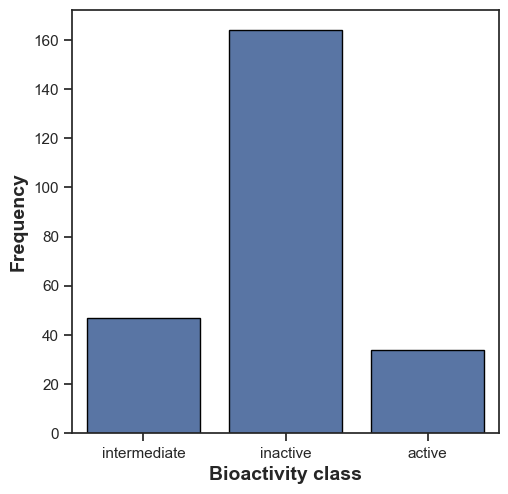

In [94]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_final, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

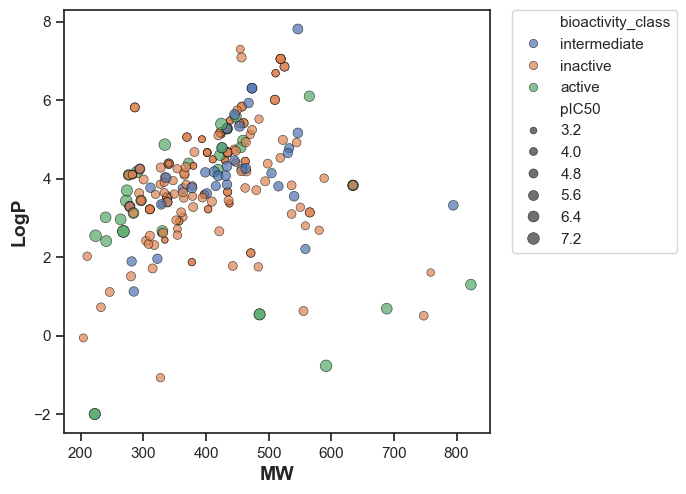

In [95]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_final, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

Text(0, 0.5, 'pIC50 value')

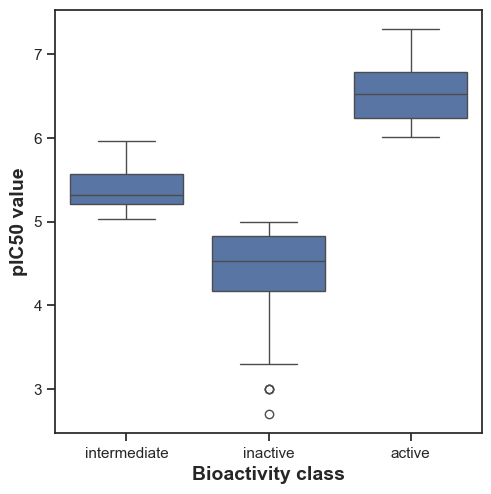

In [96]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_final)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

Function to do statistical test to see if the bioactivity class is different for any of the lipinski variables

In [136]:
def kruskal_test(input_df, descriptor, verbose=False):
    # Assuming input_df has more than two categories in 'bioactivity_class'
    
    # Define selection and filter data
    selection = [descriptor, 'bioactivity_class']
    df = input_df[selection]

    # Drop rows where the descriptor or bioactivity_class is NaN
    df = df.dropna(subset=[descriptor, 'bioactivity_class'])

    # Check if there are at least two unique categories
    categories = df['bioactivity_class'].unique()
    if len(categories) < 2:
        raise ValueError("Not enough categories in 'bioactivity_class' for the Kruskal-Wallis test.")

    # Prepare list of values for each category
    values = [df[df['bioactivity_class'] == category][descriptor].values for category in categories]

    # Check if all values are numeric
    if not all(isinstance(val, (int, float)) for val in df[descriptor].dropna()):
        raise ValueError(f"Descriptor column '{descriptor}' must contain numeric values.")

    # Perform Kruskal-Wallis H-test
    stat, p = kruskal(*values)

    # Interpretation
    alpha = 0.05
    if p > alpha:
        interpretation = 'Same distribution (fail to reject H0)'
    else:
        interpretation = 'Different distribution (reject H0)'

    # Prepare results
    results = pd.DataFrame({
        'Descriptor': [descriptor],
        'Statistics': [stat],
        'p': [p],
        'alpha': [alpha],
        'Interpretation': [interpretation]
    })

    # Save results to CSV
    filename = 'kruskal_test_' + descriptor + '.csv'
    results.to_csv(filename)

    # Optionally print results
    if verbose:
        print(results)

    plt.figure(figsize=(5.5, 5.5))

    sns.boxplot(x = 'bioactivity_class', y = descriptor, data = input_df)

    plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
    plt.ylabel('MW', fontsize=14, fontweight='bold')

    return results

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,168.493297,2.583125e-37,0.05,Different distribution (reject H0)


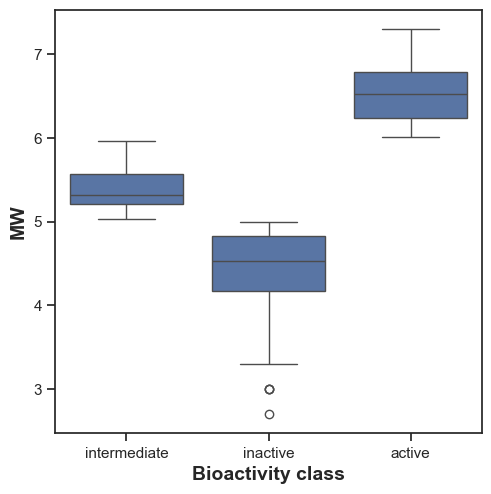

In [144]:
sns.set(style='ticks')

kruskal_test(df_final, 'pIC50')

In [145]:
df_final.columns


Index(['molecule_chembl_id', 'canonical_smiles', 'standard_value',
       'bioactivity_class', 'MW', 'LogP', 'NumHDonors', 'NumHAcceptors',
       'pIC50'],
      dtype='object')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,5.834398,0.054085,0.05,Same distribution (fail to reject H0)


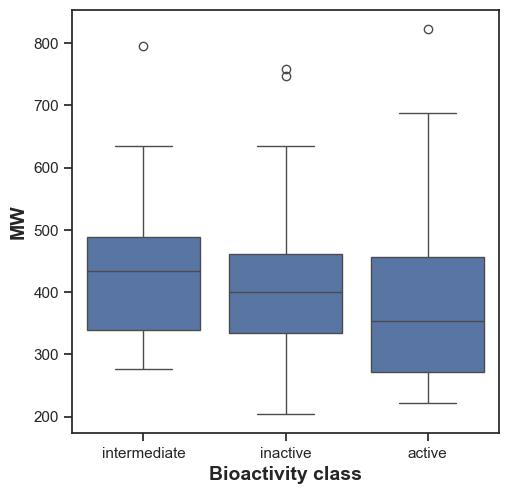

In [146]:
kruskal_test(df_final, 'MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,4.981467,0.082849,0.05,Same distribution (fail to reject H0)


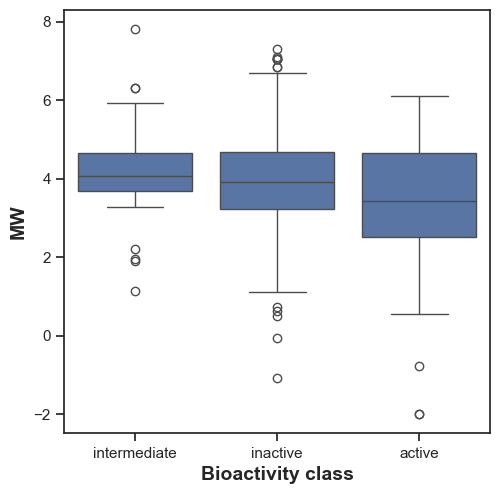

In [147]:
kruskal_test(df_final, 'LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,8.042106,0.017934,0.05,Different distribution (reject H0)


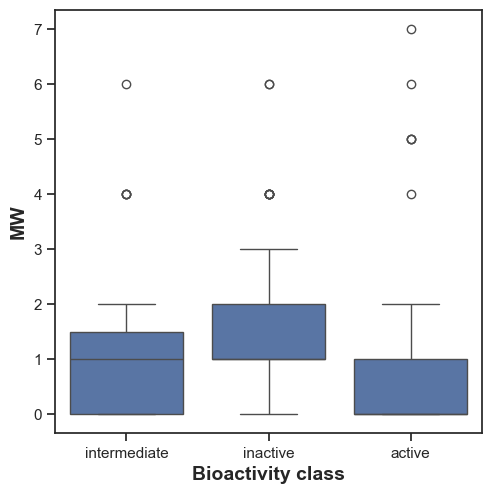

In [148]:
kruskal_test(df_final, 'NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,4.093982,0.129123,0.05,Same distribution (fail to reject H0)


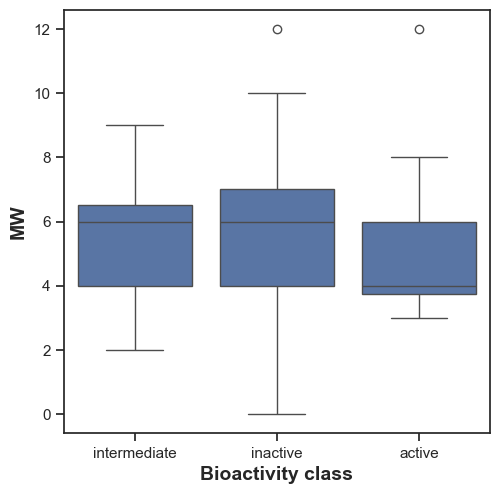

In [149]:
kruskal_test(df_final, 'NumHAcceptors')